# gluonts12-end_dates (yearly, deepar)

This notebook is used to check the performance of `deepar` on the yearly subsets of the m4 data with the same end dates. 

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.2
1.4.1


INFO:root:Using CPU


In [2]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

## Check datasets

In [5]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


**To do:** Transfer the quarterly datasets to the right place: 

- `mv [data] ../../.mxnet/gluon-ts/datasets

In [3]:
dataname = "m4_yearly_end2009"
dataset = get_dataset(dataname, regenerate=False)
len(dataset.train) # 6029

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.


6029

In [16]:
dataname = "m4_yearly_end1991"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train) # 3496

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end1991.


3496

In [4]:
dataname = "m4_yearly_end2004"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train) # 984

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2004.


984

In [5]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
length train dataset 984
length test dataset 984


In [6]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='12M'),
 'item_id': 'Y93',
 'target': array([6299.2856, 6617.7515, 6646.9556, 6842.242 , 7000.5493, 7203.311 ,
        7294.1323, 7729.0674, 7524.5405, 7373.8843, 6889.815 , 6864.537 ,
        6739.244 , 6831.9272, 6880.068 , 6516.8657, 7248.7617, 7815.169 ,
        8591.859 , 8721.834 , 7833.4243, 7720.185 , 7989.667 , 8207.53  ,
        8696.773 , 8662.692 , 8507.0205, 8166.554 , 8199.917 , 8267.792 ,
        8477.086 , 8176.0806, 8494.96  , 8766.62  , 8753.1875, 8462.25  ,
        7992.9634, 8161.5757, 8084.239 , 8255.591 , 8234.398 , 8303.153 ,
        8173.5044, 8284.113 , 8290.9375, 8055.8843], dtype=float32),
 'feat_static_cat': array([1], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2004/train/m4_yearly_end2004_train.json'), line=1), row=1)}

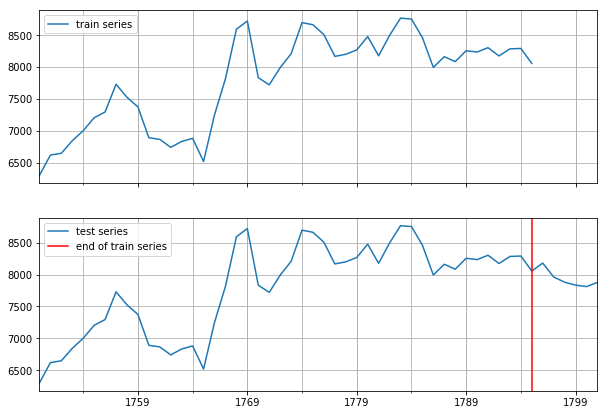

In [7]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [8]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [9]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

## Study 1: `m4_yearly_end2009`

In [ ]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2009", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 331173
100%|██████████| 200/200 [00:14<00:00, 13.89it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 14.401 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.686536
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 15.12it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[1] Elapsed time 13.231 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.216629
INFO:root:Epoch[2] Learning rate is 0.001
 66%|██████▌   | 131/200 [00:10<00:05, 13.00it/s, avg_epoch_loss=7.02]

## Study 2: `m4_yearly_end1991`

In [ ]:
# results = pd.DataFrame()

# for i in range(42, 52):
#     print("Seed:", i)
#     df = deepar(data="m4_yearly_end1991", seed=i, epochs=400, batches=200)
#     pprint(df)
#     results = results.append(df)

# results

## Study 3: `m4_yearly_end2004`

In [ ]:
results = pd.DataFrame()

for i in range(44, 47):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2004", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results